In [5]:
import dotenv

dotenv.load_dotenv()

True

# Crag

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001")
)
retriever = vectorstore.as_retriever()


In [7]:
from typing import Dict, TypedDict
from langchain_core.messages import BaseMessage

class GraphState(TypedDict):
    """"
    Represents the state of an agent in the conversation.

    Attributes:
        keys: A dictionary where each key is a string and value is expected to be a list or
        another struccture tha supports addition with `operator.add`. This could be used, for instance, to accmulate messages
        or other pieces of data throughout the graph.
    """
    keys: Dict[str, any]

In [44]:
import json
import operator
from typing import Annotated, Sequence, TypedDict
from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.prompts import PromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_chroma import Chroma
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents
    Args: 
        state(dict): The current state of the graph, which includes the keys.
    Return:
        dict: new key added to state, documents, that contains documents
        """
    print("---RETRIEVE---")
    state_dict = state["keys"]
    question = state_dict['question']
    documents = retriever.get_relevant_documents(question)
    return {"keys": {"documents": documents, 'question': question}}
    
def generate(state):
    """
    Generate answer
    args: 
        state(dict): The current state of the graph, which includes the keys.
    Return:
     dict: new key added to state, answer, that contains the generated answer"""
    print("---GENERATE---")
    state_dict = state["keys"]
    documents = state_dict['documents']
    question = state_dict['question']
    prompt = hub.pull("rlm/rag-prompt")

    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
        temperature=0.0,
    )
    def format_docs(docs):
        return "\n\n".joint(doc.page_content for doc in docs)
    
    rag_chain = (
        prompt
        | llm
        | StrOutputParser()
    )
    generation = rag_chain.invoke({'context': documents, "question": question})
    return {"keys": {"documents":documents,"generation": generation, 'question': question}}

def grade_documents(state):
    """Determines whether the retrieved documents are relevant to the question."""
    print("---CHECK RELEVANCE---")
    state_dict = state["keys"]
    documents = state_dict['documents']
    question = state_dict['question']
    class grade(BaseModel):
        """Binary score for relevance check"""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    model = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0.0,
    )
    grade_tool_oai = convert_to_openai_tool(grade)
    llm_with_tool = model.with_structured_output(grade)
    
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved documents to a user question.\n
        Here is the retrieved documents:\n\n{documents}\n\n
        Here is the user question:\n\n{question}\n\n
        If the docuemnt cotains keyword(s) or semantic meaning related to the user question, grade it as relevant.\n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question"""
    )
    chain = prompt | llm_with_tool 

    # Score
    filtered_docs = []
    search = "No"
    for d in documents:
        score = chain.invoke({"documents": d.page_content, "question": question})
        grade_of = score.binary_score
        if grade_of == "yes":
            print("---GRADE: DOCUMENT IS RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT IS NOT RELEVANT---")
            search = "Yes"
            continue
    return {
        "keys":{
            "documents": filtered_docs,
            "question": question,
            "run_web_search": search
        }
    }


def transform_query(state):
    """
    Transform the question to produce a better question
    Args:
        state(dict): The current state of the graph, which includes the keys.
    Return:
        dict: new key added to state, query, that contains the transformed query
    """
    print("---TRANSFORM QUERY---")
    state_dict = state["keys"]
    question = state_dict['question']
    documents = state_dict['documents']

    prompt = PromptTemplate(
        template="""You are generating question that is well optimized for retrieval. \n
        Look a the input and try to reason about the underying semantic intent / meaning.\n
        Here is the initial question:
        \n --------- \n
        {question}
        \n --------- \n

        Imporved question: """,
        input_variables=["question"],
    )
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
        temperature=0.0,    )
    chain = prompt | llm | StrOutputParser()
    better_question = chain.invoke({"question": question})

    return {'keys': {'documents': documents, 'question':  better_question}}

def web_search(state):
    """
    Web searc using Tavily.
    Args:
        state(dict): The current state of the graph, which includes the keys.
    Returns:
        state(dict): Web results appended to documents
    """
    print("---WEB SEARCH---")
    state_dict = state["keys"]
    question = state_dict['question']
    documents = state_dict['documents']
    
    tool = TavilySearchResults()
    docs = tool.invoke({"query": question})
    web_results = "\n".join(d['content'] for d in docs)
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {'keys': {'documents': documents, 'question': question}}

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question
    
    Args:
        state(dict): The current state of the graph, which includes the keys.

    Returns:
    dict: new key added to state, generate, that contains the decision to generate an answer or not
    """
    print("---DECIDE TO GENERATE---")
    state_dict = state["keys"]
    filtered_docs = state_dict['documents']
    question = state_dict['question']
    search = state_dict['run_web_search']

    if search == "Yes":
        print("---DECISION: TRANSFORM QUERY and RUN WEB SEARCH---")
        return "transform_query"
    else:
        print("---DECISION: GENERATE---")
        return "generate"

In [45]:
import pprint
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search", web_search)

workflow.set_entry_point("retrieve")
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "generate": "generate",
        "transform_query": "transform_query",
    }
)
workflow.add_edge('transform_query', 'web_search')
workflow.add_edge('web_search', 'generate')
workflow.add_edge('generate', END)

app = workflow.compile()

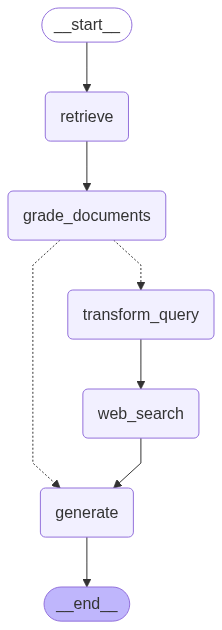

In [50]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [47]:

inputs = {'keys': {'question': 'How does alpha zero'}}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint('---------')
        pprint.pprint(value['keys'], indent=2, width=80, depth=None)
    pprint.pprint("\n----\n")

---RETRIEVE---
"Output from node 'retrieve':"
'---------'
{ 'documents': [ Document(id='0f4a76bc-eaca-47b7-bd18-3d32d1398ede', metadata={'title': "Adversarial Attacks on LLMs | Lil'Log", 'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/', 'language': 'en', 'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.\nA large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space. Attacks for discrete data like text have been considered to be a lot more challenging, due to lack of direct gradient signals. My past post on Controllable Text Generation is 

C:\Users\petro_m\AppData\Local\Temp\ipykernel_8172\1766876337.py:151: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults()


"Output from node 'web_search':"
'---------'
{ 'documents': [ Document(metadata={}, page_content='Efficiency: AlphaZero could automate repetitive coding tasks, freeing up developers for more complex work. · Innovation: By exploring uncharted\n**AlphaZero** is a [computer program](/wiki/Computer_program "Computer program") developed by [artificial intelligence](/wiki/Artificial_intelligence "Artificial intelligence") research company [DeepMind](/wiki/DeepMind "DeepMind") to master the games of [chess](/wiki/Chess "Chess"), [shogi](/wiki/Shogi "Shogi") and [go](/wiki/Go_(game) "Go (game)"). This [algorithm](/wiki/Algorithm "Algorithm") uses an approach similar to [AlphaGo Zero](/wiki/AlphaGo_Zero "AlphaGo Zero"). [...] On December 5, 2017, the DeepMind team released a [preprint](/wiki/Preprint "Preprint") paper introducing AlphaZero,[[1]](#cite_note-1) which would soon play three games by defeating world-champion chess engines [Stockfish](/wiki/Stockfish_(chess) "Stockfish (chess)"), [El